<a href="https://colab.research.google.com/github/therishabhmittal-05/music/blob/main/NonSpeech7k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! unzip /content/drive/MyDrive/6967442.zip

Archive:  /content/drive/MyDrive/6967442.zip
 extracting: train.zip               
 extracting: youtube ID vs link .TXT  
 extracting: test.zip                
 extracting: metadata of train set .csv  
 extracting: metadata of test set.csv  


In [ ]:
# !unzip /content/train.zip

In [ ]:
import pandas as pd
import numpy as np
import torch
import librosa
import cv2
import os
from tqdm import tqdm

In [ ]:
ds = pd.read_csv("/content/metadata of train set .csv")
ds.head()

,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/


In [ ]:
class_ind = {
    'breath' : 0,
    'cough' : 1,
    'crying' : 2,
    'laugh' : 3,
    'screaming' : 4,
    'sneeze' : 5,
    'yawn' : 6
}
def class_index(ds):
  ds['label'] = ds.Classname.map(class_ind)

class_index(ds)
ds.head()
n_labels = len(class_ind)

In [ ]:
class config:
  in_dir = "/content/train/"
  out_dir = "/content/mel_spectrograms/"
  sr = 32000
  n_fft = 1024
  hop_length = 256
  n_mels = 128
  fmin = 20
  fmax = 16000
  t_shape = (256, 256)

In [ ]:
import IPython.display as ip
audio = config.in_dir + ds.Filename[0]
label = ds.Classname[0]
print(label)
print(audio)
ip.Audio(audio)

breath
/content/train/108160-1_0_0.wav


breath
(128, 322)


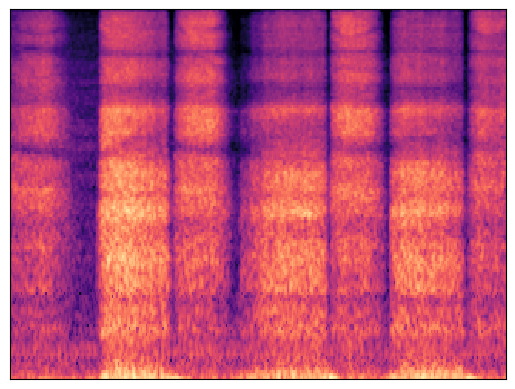

In [ ]:
y, sr = librosa.load(audio)

mel = librosa.feature.melspectrogram(
    y=y,
    sr = config.sr,
    n_fft = config.n_fft,
    hop_length = config.hop_length,
    n_mels = config.n_mels,
    fmin = config.fmin,
    fmax = config.fmax
)
mel = librosa.power_to_db(mel, ref = np.max)
librosa.display.specshow(mel)
print(label)
print(mel.shape)

In [ ]:
# mel = get_mel(audio)
# librosa.display.specshow(mel)

In [ ]:
def get_mel(y):
  mel = librosa.feature.melspectrogram(
      y=y,
      sr = config.sr,
      n_fft = config.n_fft,
      hop_length = config.hop_length,
      n_mels = config.n_mels,
      fmin = config.fmin,
      fmax = config.fmax
  )
  mel = librosa.power_to_db(mel, ref = np.max)
  mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
  return mel

In [ ]:
for i, row in tqdm(ds.iterrows(), total=len(ds)):
  audio = config.in_dir + row.Filename
  y, _ = librosa.load(audio)
  mel = get_mel(y)
  if mel.shape != config.t_shape:
    mel = cv2.resize(mel, config.t_shape, interpolation = cv2.INTER_LINEAR)
  out_path = f"{config.out_dir}{row.Classname}_{row.label}_{i}.npy"
  np.save(out_path, mel.astype(np.float32))

100%|██████████| 6289/6289 [02:04<00:00, 50.53it/s]


In [ ]:
test = config.out_dir + os.listdir(config.out_dir)[1]
mel = np.load(test)
print(mel)
print(os.path.basename(test).split('_')[0])

[[0.2145857  0.25563613 0.21716554 ... 0.31353614 0.28273737 0.18492359]
 [0.20423454 0.23626111 0.21272762 ... 0.29620203 0.27416897 0.18359806]
 [0.18353222 0.19751108 0.20385177 ... 0.2615338  0.25703216 0.18094699]
 ...
 [0.07365039 0.16043527 0.21829633 ... 0.11241201 0.03329669 0.00165872]
 [0.02455013 0.06114982 0.10680182 ... 0.05899606 0.0110989  0.00055291]
 [0.         0.01150709 0.05105456 ... 0.03228809 0.         0.        ]]
cough


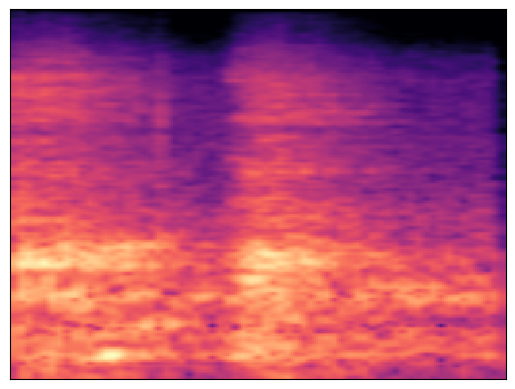

In [ ]:
librosa.display.specshow(mel)

In [ ]:
# len(os.listdir("/content/mel_spectrograms"))
files= [f for f in os.listdir("/content/mel_spectrograms") if f.endswith('.npy')]

In [ ]:
files[0].split('_')[1]
# filepath = os.path.join("/content/mel_spectrograms/", files[0])
# print(filepath)

'0'

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
class NonSpeech(Dataset):
  def __init__(self, mel_dir):
    self.mel_dir = mel_dir # /content/mel_spectrograms/
    self.files = [f for f in os.listdir(self.mel_dir) if f.endswith('.npy')]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    filename = self.files[idx]
    filepath = os.path.join(self.mel_dir, filename)
    img = np.load(filepath)
    img = torch.from_numpy(img)
    img = img.repeat(3, 1, 1)

    label = torch.tensor(int(filename.split('_')[1]), dtype = torch.long)

    return img, label

In [ ]:
NonSpeechDs = NonSpeech(config.out_dir)

In [ ]:
for i, (sample, label) in enumerate(NonSpeechDs):
    print(f"{i}: {sample.size()}, {label}")
    break

0: torch.Size([3, 256, 256]), 0


In [ ]:
NonSpeechDs[100][0]

tensor([[[5.4948e-01, 5.1544e-01, 5.4653e-01,  ..., 4.6857e-01,
          5.2179e-01, 5.1004e-01],
         [5.4096e-01, 5.0721e-01, 5.4430e-01,  ..., 4.6648e-01,
          5.1731e-01, 5.0176e-01],
         [5.2393e-01, 4.9074e-01, 5.3985e-01,  ..., 4.6229e-01,
          5.0834e-01, 4.8519e-01],
         ...,
         [3.7600e-01, 3.9042e-01, 4.1660e-01,  ..., 5.1187e-04,
          6.1712e-03, 1.5008e-03],
         [3.1042e-01, 2.6768e-01, 2.7920e-01,  ..., 1.7062e-04,
          2.0571e-03, 5.0026e-04],
         [2.7763e-01, 2.0630e-01, 2.1051e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[5.4948e-01, 5.1544e-01, 5.4653e-01,  ..., 4.6857e-01,
          5.2179e-01, 5.1004e-01],
         [5.4096e-01, 5.0721e-01, 5.4430e-01,  ..., 4.6648e-01,
          5.1731e-01, 5.0176e-01],
         [5.2393e-01, 4.9074e-01, 5.3985e-01,  ..., 4.6229e-01,
          5.0834e-01, 4.8519e-01],
         ...,
         [3.7600e-01, 3.9042e-01, 4.1660e-01,  ..., 5.1187e-04,
          6.171

In [ ]:
train_size = int(0.8 * len(NonSpeechDs))
val_size = len(NonSpeechDs) - train_size
NonSpeech_train, NonSpeech_val = random_split(NonSpeechDs, [train_size, val_size])

In [ ]:
NonSpeech_train[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
batch_size=32
train_load = DataLoader(NonSpeech_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_load = DataLoader(NonSpeech_val, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
for x, y in train_load:
    print(f"{x.shape} : {y.shape}")
    break

torch.Size([32, 3, 256, 256]) : torch.Size([32])


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import torch.nn as nn

In [ ]:
base = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
print(base.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:02<00:00, 80.7MB/s]


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [ ]:
class NonSpeechModel(nn.Module):
  def __init__(self, n_labels):
    super().__init__()
    base = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
    self.features = base.features
    self.avg_pool = base.avgpool
    self.classifier = nn.Linear(base.classifier[1].in_features, n_labels)
  def forward(self, x):
    x = self.features(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = NonSpeechModel(n_labels).to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 12797 has 14.74 GiB memory in use. Of the allocated memory 14.60 GiB is allocated by PyTorch, and 23.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# from torchsummary import summary
# summary(model, (3, 256, 256))

In [ ]:
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
def train(model, train_load, optimizer, scheduler, criterion, n_epochs=50):
  losses = []
  accuracies = []

  for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for sample, label in tqdm(train_load, total=len(train_load)):
      sample = sample.to(device)
      label = label.to(device)

      optimizer.zero_grad()
      yhat = model(sample)
      loss = criterion(yhat, label)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * sample.size(0)

      preds = torch.argmax(yhat, dim=1)
      correct += (preds == label).sum().item()
      total += label.size(0)

    epoch_loss = running_loss / len(train_load.dataset)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    scheduler.step(losses[-1])
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
  return losses, accuracies

In [ ]:
losses, accuracies = train(model, train_load, optimizer, scheduler, criterion, n_epochs=10)
losses, accuracies

  0%|          | 0/79 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 4.12 MiB is free. Process 12797 has 14.73 GiB memory in use. Of the allocated memory 14.59 GiB is allocated by PyTorch, and 25.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
plt.plot(accuracies)
plt.show()

In [37]:
ls -al

total 2480556
drwxr-xr-x 1 root root       4096 May 13 12:05  ./
drwxr-xr-x 1 root root       4096 May 13 11:59  ../
drwxr-xr-x 4 root root       4096 May  9 13:41  .config/
drwx------ 6 root root       4096 May 13 12:04  drive/
drwxr-xr-x 2 root root       4096 May 13 12:05  .ipynb_checkpoints/
drwxr-xr-x 2 root root     253952 May 13 12:10  mel_spectrograms/
-rw------- 1 root root      51845 May 12 10:25 'metadata of test set.csv'
-rw------- 1 root root     478461 May 12 10:25 'metadata of train set .csv'
drwxr-xr-x 1 root root       4096 May  9 13:41  sample_data/
-rw------- 1 root root  221775350 May 12 10:23  test.zip
drwxr-xr-x 2 root root     274432 May 13 12:06  train/
-rw------- 1 root root 2317217784 May 12 10:08  train.zip
-rw------- 1 root root       1363 May 12 10:23 'youtube ID vs link .TXT'


In [38]:
!du -sh mel_spectrograms/

1.6G	mel_spectrograms/
